In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp

# import random

# Генерация данных

## Функция для вычисления приращений концентраций веществ

In [51]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

Функция true_ode_func задается на основе матрицы S. В данном примере матрицы S имеет следующий вид:

$$
S = \begin{bmatrix}
-2 & 1  & 0  & 0  & 0\\
-1 & 0  & 1  & 0  & 0 \\
0  & 0  & -1 & 1  & 0 \\
0  & -1 & 0  & -1 & 1\\
\end{bmatrix}
$$

## Константы

In [82]:
N_REACTION = 4                                                           # кол-во реакций
N_SUBSTANCE = 5                                                          # кол-во веществ
VR_TIME = 40                                                             # время протекания реакций
# INIT_CONC = np.array([1.0, 0.5, 0.1, 0.4, 0])                            # начальные концентрации веществ
# k = np.array([0.2, 0.1, 0.13, 0.3])                                      # константы скоростей реакций

# INIT_CONC = np.array([0.05, 0.02, 0.01, 0.03, 0.00])
# k = np.array([0.01, 0.005, 0.007, 0.02])

# INIT_CONC = np.array([1.0, 0.8, 0.3, 0.5, 0])
# k = np.array([0.15, 0.1, 0.12, 0.18])

# INIT_CONC = np.array([2.0, 1.5, 1.0, 1.2, 0])
# k = np.array([0.5, 0.3, 0.4, 0.6])

# INIT_CONC = np.array([0.1, 0.05, 0.02, 0.08, 0])
# k = np.array([0.002, 0.001, 0.0015, 0.003])

# INIT_CONC = np.array([3.0, 2.5, 1.8, 2.0, 0])
# k = np.array([0.8, 0.6, 0.7, 0.9])

# Комбинированные
INIT_CONC = np.array([5.0, 3.0, 1.8, 2.5, 0])  
k = np.array([0.7, 0.05, 0.4, 0.01])  

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(0, VR_TIME, VR_TIME*3 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


## Вычисление и визуализация изменения концентраций веществ со временем

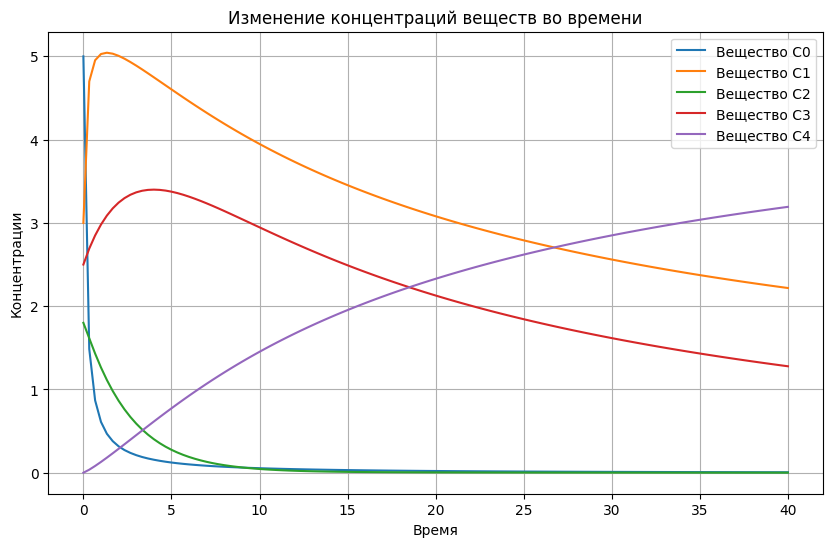

In [83]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i}')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid()
plt.show()

# Сохранение сгенерированных концентраций C в моменты времени. Понадобятся в будущем
CONC_TRUE = sol.y.copy()

## Добавление шума

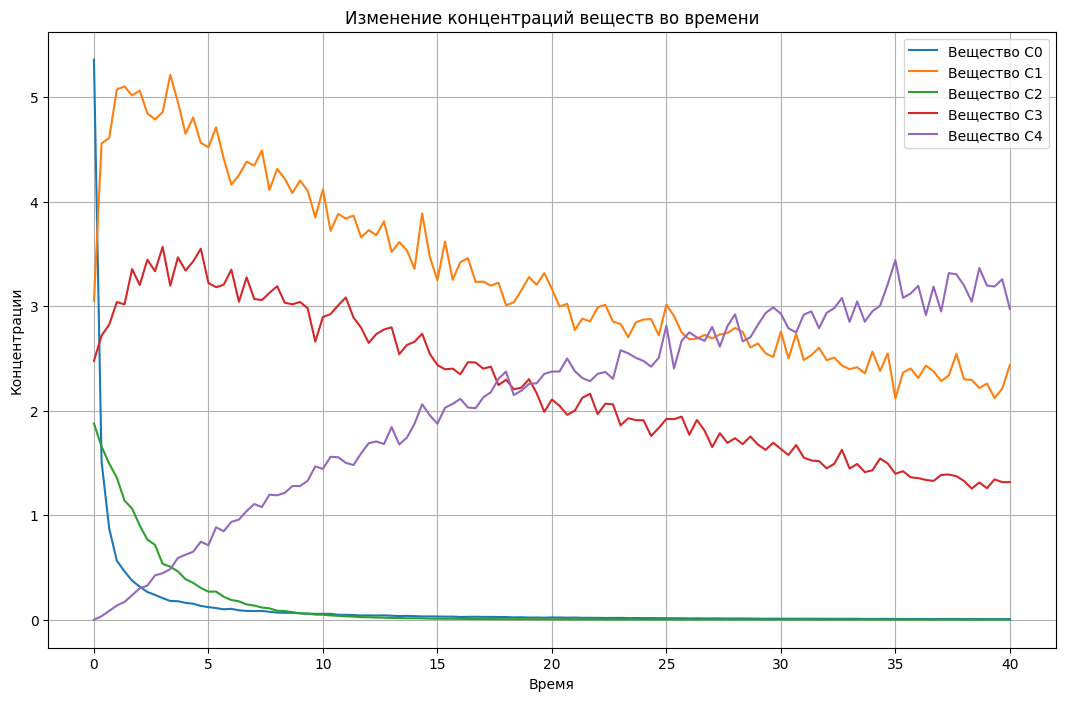

In [84]:
noise_level = 4e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

np.random.seed(3)
noise = np.random.normal(0, noise_level * np.abs(y_noisy))          #  это шум
y_noisy += noise                                                    #  это шум

# Построение графиков
plt.figure(figsize=(13, 8))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество C{i}')
    # plt.plot(sol.t, sol.y[i])

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


## Сохранение данных

### В формате excel

In [85]:
df = pd.DataFrame(y_noisy.T, columns=[f'C{i}' for i in range(N_SUBSTANCE)])

output_dir = "gen_data" 
os.makedirs(output_dir, exist_ok=True)                      # Содание папки, если такой нет

file_path = os.path.join(output_dir, "generate_concentrations_comb.xlsx")
df.to_excel(file_path, index=False)

### В формате csv

In [ ]:
# df = pd.DataFrame(y_noisy.T, columns=['C0', 'C1', 'C2', 'C3', 'C4',])
# df.to_csv("generate_concentrations_comb.csv", index=False)
# print(df)

           C0        C1        C2        C3        C4
0    5.357726  3.051172  1.876840  2.476037  0.000000
1    1.512239  4.557502  1.656314  2.719067  0.033708
2    0.871990  4.608102  1.493897  2.823221  0.084328
3    0.564470  5.073808  1.358480  3.039487  0.136192
4    0.462875  5.101808  1.140428  3.017238  0.170089
..        ...       ...       ...       ...       ...
116  0.006209  2.217129  0.000868  1.313068  3.364727
117  0.006003  2.259009  0.000877  1.258556  3.196984
118  0.005583  2.121909  0.000849  1.342987  3.187844
119  0.005970  2.210007  0.000883  1.316413  3.257265
120  0.005406  2.436231  0.000788  1.316545  2.974275

[121 rows x 5 columns]
